In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import string
from nltk.corpus import stopwords
stopWords = set(stopwords.words("english"))
stopWords.add("im")

In [3]:
train = pd.read_csv("../data/train.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### some simple word processing functions

In [171]:
punct = set(string.punctuation)
print(string.punctuation)

def loudness(line):
    '''
    unstripped line
    '''
    uppers = set(string.ascii_uppercase)
    all_chars = set(string.ascii_letters)
    
    upper_count = 0
    all_count = 0
    for ch in line:
        if ch in all_chars:
            all_count += 1
            
            if ch in uppers:
                upper_count += 1
    
#     print("loudness: {:0.4f}".format(upper_count / (all_count * 1.0)))
    return upper_count / (all_count * 1.0 + 0.000001)  # make compatible with python 2.7 if others use

def repeating(line):
    '''
    stripped line prob works best
    '''
    
    temp = line.split()
    
    return 1.0 - (len(set(temp)) / (len(temp) * 1.0 + 0.000001))

def build_vocab(line, v_dict, swords):
    '''
    parse the current line and add to v_dict counts
    '''
    
    word_list = line.split()
    
    # figure out how repetitious a line is so if it repeats a lot only add the first 10 words
    # so that one comment with something repeated 500 times doesn't blow out the vocab count
    if repeating(line) > 0.95:
        word_list = word_list[:10]
    
    # for each word in the line
    for word in word_list:
        
        # skip stop words for frequency count type stuff
        if word not in swords and len(word) > 1:

            # see if the word is in the vocab, if so increment
            if word in v_dict:
                v_dict[word] += 1

            # otherwise add word to dict with count of 1
            else:
                v_dict[word] = 1
        

def repeating_strip_line(line):
    rep = repeating(line)
    
    # if the sentence is very repetitive
    if rep > 0.9:
        
        # chop it and return the chopped version
        return line[:40]
    
    else:
        return line
    
def strip_line(line):
    line = line.replace(",", " ").replace("\n", " ")
    line = line.replace("..", " ").replace("??", " ").replace("!!", " ")
    line = line.replace(". ", " EOS ").replace("? ", " EOS ").replace("! ", " EOS ")
    line = "".join([_c if _c not in punct else " " for _c in line])
    
    word_list = line.lower().split()
    
    # if a sentence doesn't have eos add it?
    # might want to remove this when evaluating, not having terminating punctuation
    # is probably signal
    if word_list[-1] != "eos":
        word_list.append("eos")
        
    line = " ".join(word_list)
#     print(line)
    
#     if "yourselfgo" in line:
#         print("#########", line)
    
    return line

def punctuation_ratio(line):
    punct = set(string.punctuation)
    
    _c = 0
    
    for ch in line:
        if ch in punct:
            _c += 1
            
    return _c / (len(line.split()) + 0.000001)

def urgency_ratio(line):
    _c = line.count("!")
    return _c / (len(line.split()) + 0.000001)

def question_ratio(line):
    _c = line.count("?")
    return _c / (len(line.split()) + 0.000001)
    
def period_ratio(line):
    _c = line.count(".")
    return _c / (len(line.split()) + 0.000001)

# might be some pattern in length of messages?
def count_words(line):
    return len(line.split())



!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [172]:
good_stuff = train[np.sum(train.loc[:, ["toxic", "severe_toxic", "obscene", "insult", "threat", "identity_hate" ]], axis=1) == 0]

good_stuff.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0


In [195]:
bad_stuff = train[np.sum(train.loc[:, ["toxic", "severe_toxic", "obscene", "insult", "threat", "identity_hate" ]], axis=1) > 0]

bad_stuff.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
44,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0


### Accumulate feature data

In [174]:
# see how things look if repetative comments are concatenated so that they have less influence
good_stuff.loc[:, "comment_text"] = good_stuff.loc[:, "comment_text"].apply(repeating_strip_line)

good_stuff.loc[:, "loudness"] = good_stuff.loc[:, "comment_text"].apply(loudness)
good_stuff.loc[:, "punc_ratio"] = good_stuff.loc[:, "comment_text"].apply(punctuation_ratio)
good_stuff.loc[:, "urgency_r"] = good_stuff.loc[:, "comment_text"].apply(urgency_ratio)
good_stuff.loc[:, "questioning_r"] = good_stuff.loc[:, "comment_text"].apply(question_ratio)
good_stuff.loc[:, "dot_r"] = good_stuff.loc[:, "comment_text"].apply(period_ratio)
good_stuff.loc[:, "word_count"] = good_stuff.loc[:, "comment_text"].apply(count_words)
good_stuff["stripped"] = good_stuff.loc[:, "comment_text"].apply(strip_line)
good_stuff["repeating"] = good_stuff.loc[:, "stripped"].apply(repeating)

/home/brian/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/brian/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [175]:
good_stuff.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,loudness,punc_ratio,urgency_r,questioning_r,dot_r,word_count,stripped,repeating
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0.083744,0.232558,0.000000,0.023256,0.116279,43,explanation why the edits made under my userna...,0.113208
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0.109589,0.705882,0.058824,0.000000,0.117647,17,d aww eos he matches this background colour i ...,0.125000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0.021505,0.142857,0.000000,0.000000,0.071429,42,hey man i m really not trying to edit war eos ...,0.106383
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0.022634,0.185841,0.000000,0.000000,0.026549,113,more i can t make any real suggestions on impr...,0.308333
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0.040000,0.384615,0.000000,0.076923,0.076923,13,you sir are my hero eos any chance you remembe...,0.125000


In [196]:
temp = bad_stuff.loc[:, "comment_text"].apply(strip_line)
bad_stuff["repeating"] = temp.apply(repeating)

# see how things look if repetative comments are concatenated so that they have less influence
bad_stuff.loc[:, "comment_text"] = bad_stuff.loc[:, "comment_text"].apply(repeating_strip_line)

bad_stuff.loc[:, "loudness"] = bad_stuff.loc[:, "comment_text"].apply(loudness).values
bad_stuff.loc[:, "punc_ratio"] = bad_stuff.loc[:, "comment_text"].apply(punctuation_ratio).values
bad_stuff.loc[:, "urgency_r"] = bad_stuff.loc[:, "comment_text"].apply(urgency_ratio).values
bad_stuff.loc[:, "questioning_r"] = bad_stuff.loc[:, "comment_text"].apply(question_ratio).values
bad_stuff.loc[:, "dot_r"] = bad_stuff.loc[:, "comment_text"].apply(period_ratio).values
bad_stuff.loc[:, "word_count"] = bad_stuff.loc[:, "comment_text"].apply(count_words).values
# bad_stuff["stripped"] = bad_stuff.loc[:, "comment_text"].apply(strip_line)
# bad_stuff["repeating"] = bad_stuff.loc[:, "stripped"].apply(repeating)

/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/brian/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/brian/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [192]:
bad_stuff.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,loudness,punc_ratio,urgency_r,questioning_r,dot_r,word_count,stripped,repeating
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1.000000,0.000000,0.000000,0.000000,0.000000,8,cocksucker before you piss around on my work eos,1.111111e-07
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,0.177686,0.452830,0.000000,0.018868,0.283019,53,hey eos what is it talk eos what is it eos an ...,2.033898e-01
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,0.073171,0.500000,0.200000,0.000000,0.100000,10,bye eos don t look come or think of comming ba...,1.428572e-01
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,0.044715,0.239316,0.059829,0.008547,0.025641,117,you are gay or antisemmitian eos archangel whi...,2.890625e-01
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,1.000000,0.250000,0.125000,0.000000,0.000000,8,fuck your filthy mother in the ass dry eos,1.111111e-07


### Loudness:

Text(0.5,1,'Distribution of Loudness\nToxic Comments')

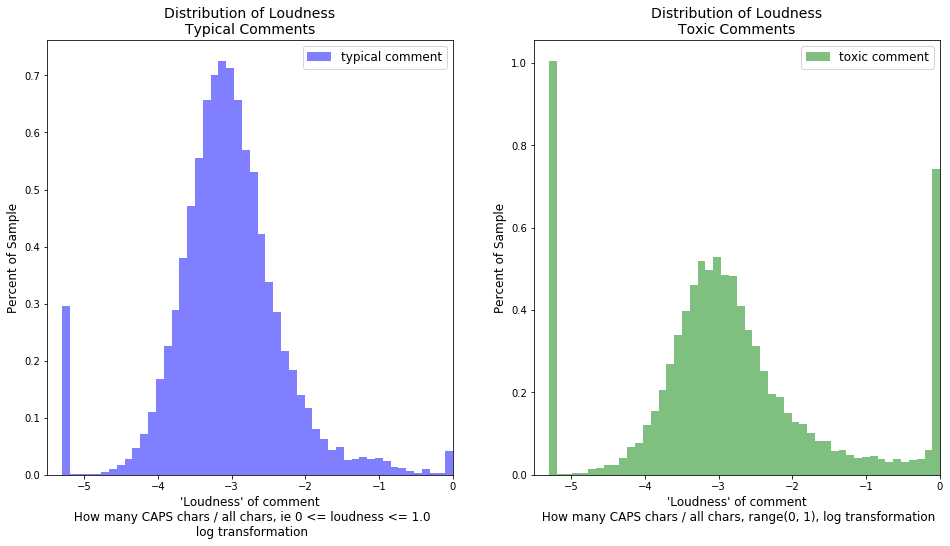

In [197]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

_ = axs[0].hist(np.log(good_stuff.loc[:, "loudness"] + 0.005), bins=50, normed=True, color='blue', alpha=0.5, label="typical comment")
_ = axs[1].hist(np.log(bad_stuff.loc[:, "loudness"] + 0.005), bins=50, normed=True, color='green', alpha=0.5, label="toxic comment")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

axs[0].set_xlabel("'Loudness' of comment\n How many CAPS chars / all chars, ie 0 <= loudness <= 1.0\n log transformation", size=12)
axs[1].set_xlabel("'Loudness' of comment\n How many CAPS chars / all chars, range(0, 1), log transformation", size=12)

axs[0].set_ylabel("Percent of Sample", size=12)
axs[1].set_ylabel("Percent of Sample", size=12)

axs[0].set_xlim(-5.5, 0)
axs[1].set_xlim(-5.5, 0)

axs[0].set_title("Distribution of Loudness\nTypical Comments", size=14)
axs[1].set_title("Distribution of Loudness\nToxic Comments", size=14)

### Repetitiveness:

Text(0.5,1,'Distribution of Repetition\nToxic Comments')

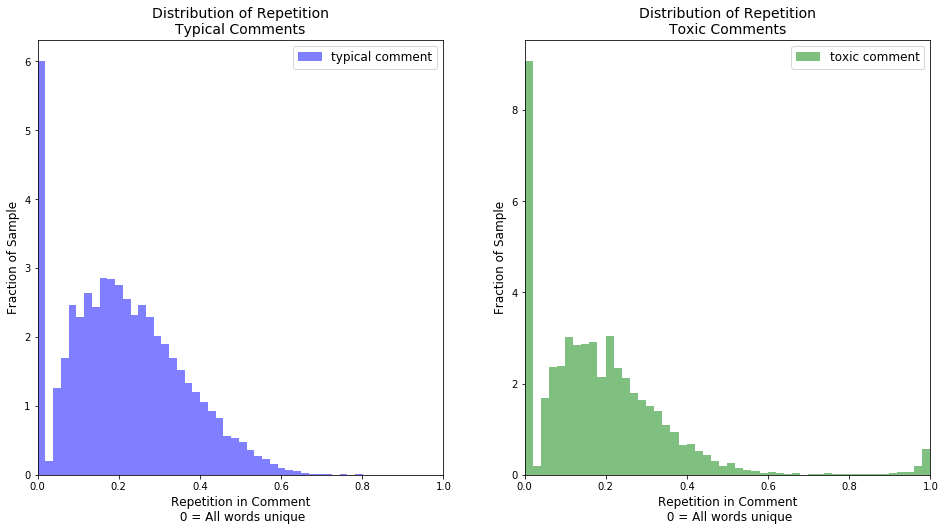

In [198]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

_ = axs[0].hist(good_stuff.loc[:, "repeating"], bins=50, normed=True, color='blue', alpha=0.5, label="typical comment")
_ = axs[1].hist(bad_stuff.loc[:, "repeating"], bins=50, normed=True, color='green', alpha=0.5, label="toxic comment")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

axs[0].set_xlabel("Repetition in Comment\n 0 = All words unique", size=12)
axs[1].set_xlabel("Repetition in Comment\n 0 = All words unique", size=12)

axs[0].set_ylabel("Fraction of Sample", size=12)
axs[1].set_ylabel("Fraction of Sample", size=12)

axs[0].set_xlim(0, 1.0)
axs[1].set_xlim(0, 1.0)

axs[0].set_title("Distribution of Repetition\nTypical Comments", size=14)
axs[1].set_title("Distribution of Repetition\nToxic Comments", size=14)

### Punctuation Ratio:  How much punctuation over how many words

In [180]:
print(bad_stuff.loc[:, "punc_ratio"].values.max())
print(bad_stuff.loc[:, "punc_ratio"].values.min())
print(bad_stuff.loc[:, "punc_ratio"].values.mean())

# Log transformation is needed, another log normal distribution

705.999899143
0.0
0.388608162355


Text(0.5,1,'Distribution of Punctuation Used\nToxic Comments')

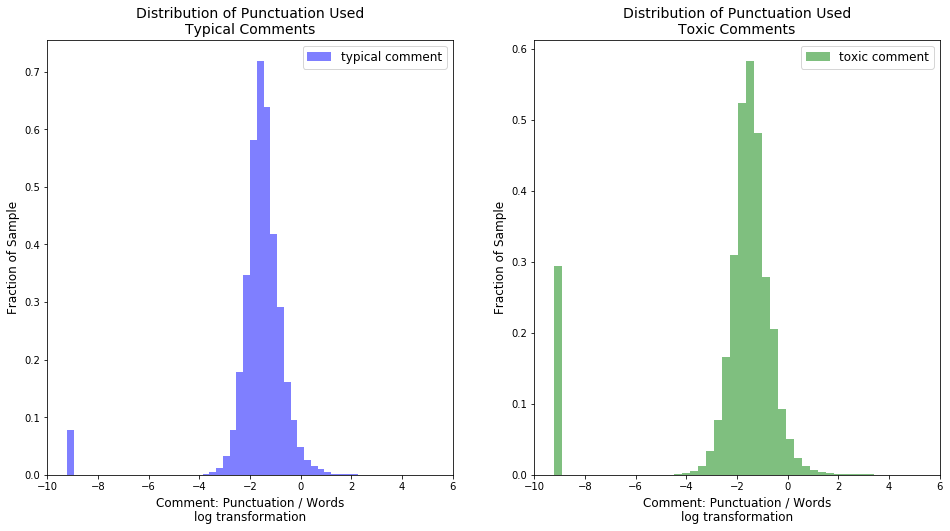

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

_ = axs[0].hist(np.log(good_stuff.loc[:, "punc_ratio"] + 0.0001), bins=50, normed=True, color='blue', alpha=0.5, label="typical comment")
_ = axs[1].hist(np.log(bad_stuff.loc[:, "punc_ratio"] + 0.0001), bins=50, normed=True, color='green', alpha=0.5, label="toxic comment")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

axs[0].set_xlabel("Comment: Punctuation / Words\nlog transformation", size=12)
axs[1].set_xlabel("Comment: Punctuation / Words\nlog transformation", size=12)

axs[0].set_ylabel("Fraction of Sample", size=12)
axs[1].set_ylabel("Fraction of Sample", size=12)

axs[0].set_xlim(-10, 6.0)
axs[1].set_xlim(-10, 6.0)

axs[0].set_title("Distribution of Punctuation Used\nTypical Comments", size=14)
axs[1].set_title("Distribution of Punctuation Used\nToxic Comments", size=14)

### Urgency: How many exclamation points per word

In [182]:
print(bad_stuff.loc[:, "urgency_r"].values.max())
print(bad_stuff.loc[:, "urgency_r"].values.min())
print(bad_stuff.loc[:, "urgency_r"].values.mean())

print("Toxic: Percent with no exclamation point: {:2.2f}%".format(
    len(bad_stuff[bad_stuff.loc[:, "urgency_r"] ==0]) /  len(bad_stuff) * 100))

print("typical: Percent with no exclamation point: {:2.2f}%".format(
    len(good_stuff[good_stuff.loc[:, "urgency_r"] ==0]) /  len(good_stuff) * 100))

# Log transformation is needed, another log normal distribution

705.999899143
0.0
0.12595678463
Toxic: Percent with no exclamation point: 73.84%
typical: Percent with no exclamation point: 87.06%


Text(0.5,1,"Distribution of Exclamations Used ('!' >= 1)\n73% of Toxic Comments Have no '!'")

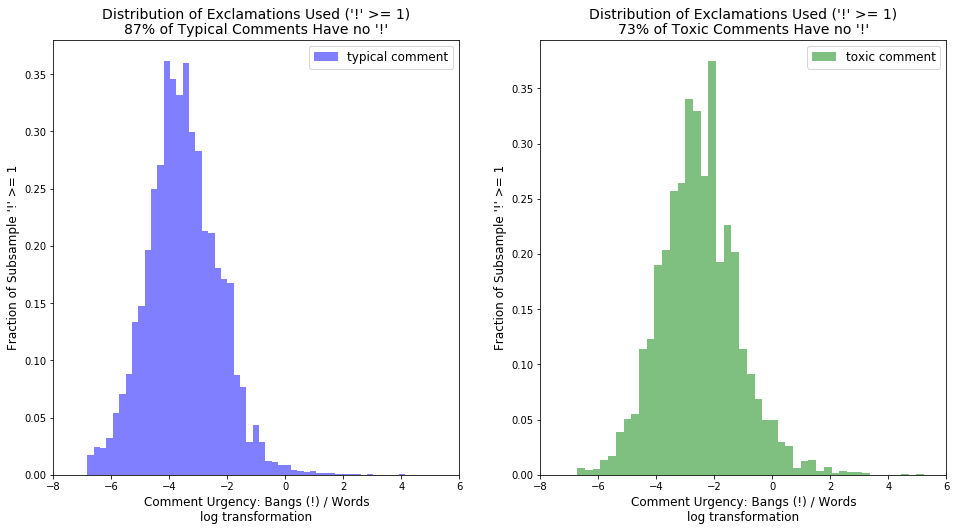

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

_good = good_stuff[good_stuff.loc[:, "urgency_r"] != 0]
_bad = bad_stuff[bad_stuff.loc[:, "urgency_r"] != 0]

_ = axs[0].hist(np.log(_good.loc[:, "urgency_r"]), bins=50, normed=True, color='blue', alpha=0.5, label="typical comment")
_ = axs[1].hist(np.log(_bad.loc[:, "urgency_r"]), bins=50, normed=True, color='green', alpha=0.5, label="toxic comment")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

axs[0].set_xlabel("Comment Urgency: Bangs (!) / Words\nlog transformation", size=12)
axs[1].set_xlabel("Comment Urgency: Bangs (!) / Words\nlog transformation", size=12)

axs[0].set_ylabel("Fraction of Subsample '!' >= 1", size=12)
axs[1].set_ylabel("Fraction of Subsample '!' >= 1", size=12)

axs[0].set_xlim(-8, 6.0)
axs[1].set_xlim(-8, 6.0)

axs[0].set_title("Distribution of Exclamations Used ('!' >= 1)\n87% of Typical Comments Have no '!'", size=14)
axs[1].set_title("Distribution of Exclamations Used ('!' >= 1)\n73% of Toxic Comments Have no '!'", size=14)

### Questioning: How many "?" per comment

In [184]:
print(bad_stuff.loc[:, "questioning_r"].values.max())
print(bad_stuff.loc[:, "questioning_r"].values.min())
print(bad_stuff.loc[:, "questioning_r"].values.mean())

print("Toxic: Percent with no '?': {:2.2f}%".format(
    len(bad_stuff[bad_stuff.loc[:, "questioning_r"] ==0]) /  len(bad_stuff) * 100))

print("Typical: Percent with no '?': {:2.2f}%".format(
    len(good_stuff[good_stuff.loc[:, "questioning_r"] ==0]) /  len(good_stuff) * 100))

# Log transformation is needed, another log normal distribution

6.14705864273
0.0
0.0168622049276
Toxic: Percent with no '?': 74.73%
Typical: Percent with no '?': 74.62%


Text(0.5,1,"Distribution of Question Marks Used ('?' >= 1)\n74% of Typical and Toxic Comments Have no '?'")

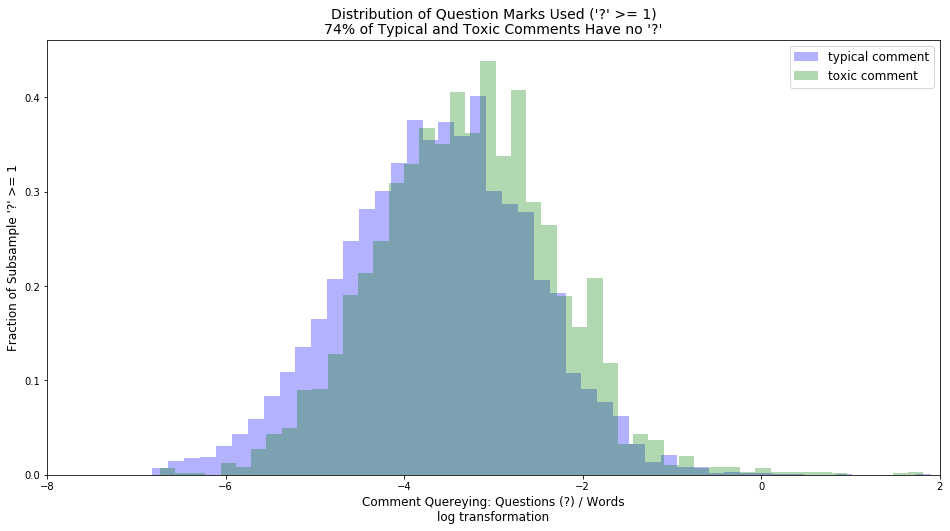

In [185]:
fig, axs = plt.subplots(figsize=(16, 8))

_good = good_stuff[good_stuff.loc[:, "questioning_r"] != 0]
_bad = bad_stuff[bad_stuff.loc[:, "questioning_r"] != 0]

_ = axs.hist(np.log(_good.loc[:, "questioning_r"]), bins=50, normed=True, color='blue', alpha=0.3, label="typical comment")
_ = axs.hist(np.log(_bad.loc[:, "questioning_r"]), bins=50, normed=True, color='green', alpha=0.3, label="toxic comment")

axs.legend(fontsize=12)
# axs[1].legend(fontsize=12)

axs.set_xlabel("Comment Quereying: Questions (?) / Words\nlog transformation", size=12)
# axs[1].set_xlabel("Comment Urgency: Questions (?) / Words\nlog transformation", size=12)

axs.set_ylabel("Fraction of Subsample '?' >= 1", size=12)
# axs[1].set_ylabel("Fraction of Subsample '?' >= 1", size=12)

axs.set_xlim(-8, 2.0)
# axs[1].set_xlim(-8, 6.0)

axs.set_title("Distribution of Question Marks Used ('?' >= 1)\n74% of Typical and Toxic Comments Have no '?'", size=14)
# axs[1].set_title("Distribution of Question Marks Used ('?' >= 1)\n74.7% of Toxic Comments Have no '?'", size=14)

### Periods:  How many sentences and ellipsis?

In [186]:
print(bad_stuff.loc[:, "dot_r"].values.max())
print(bad_stuff.loc[:, "dot_r"].values.min())
print(bad_stuff.loc[:, "dot_r"].values.mean())

print("Toxic: Percent with no '.': {:2.2f}%".format(
    len(bad_stuff[bad_stuff.loc[:, "dot_r"] ==0]) /  len(bad_stuff) * 100))

print("Typical: Percent with no '.': {:2.2f}%".format(
    len(good_stuff[good_stuff.loc[:, "dot_r"] ==0]) /  len(good_stuff) * 100))

# Log transformation is needed, another log normal distribution

32.3333297407
0.0
0.0973879134254
Toxic: Percent with no '.': 28.83%
Typical: Percent with no '.': 13.16%


Text(0.5,1,"Distribution of Exclamations Used ('.' >= 1)\n29% of Toxic Comments Have no '.'")

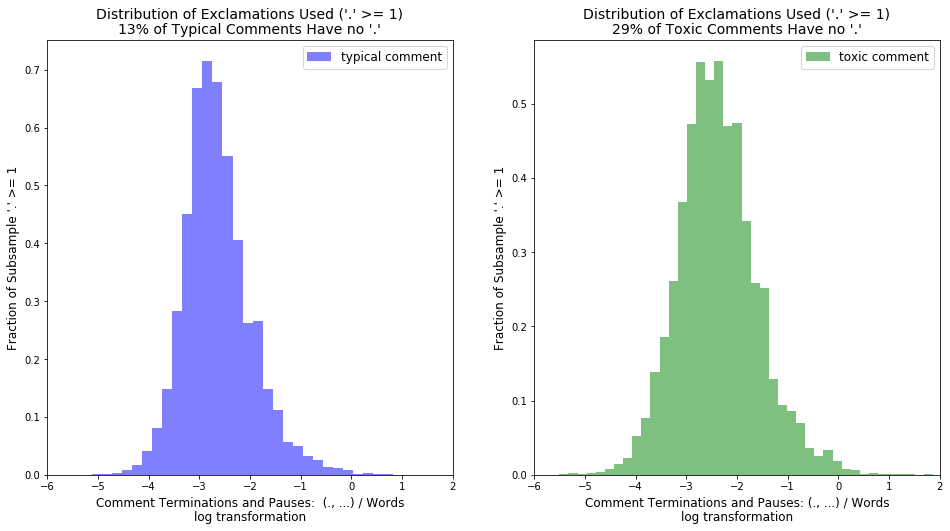

In [187]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

_good = good_stuff[good_stuff.loc[:, "dot_r"] != 0]
_bad = bad_stuff[bad_stuff.loc[:, "dot_r"] != 0]

_ = axs[0].hist(np.log(_good.loc[:, "dot_r"]), bins=50, normed=True, color='blue', alpha=0.5, label="typical comment")
_ = axs[1].hist(np.log(_bad.loc[:, "dot_r"]), bins=50, normed=True, color='green', alpha=0.5, label="toxic comment")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

axs[0].set_xlabel("Comment Terminations and Pauses:  (., ...) / Words\nlog transformation", size=12)
axs[1].set_xlabel("Comment Terminations and Pauses: (., ...) / Words\nlog transformation", size=12)

axs[0].set_ylabel("Fraction of Subsample '.' >= 1", size=12)
axs[1].set_ylabel("Fraction of Subsample '.' >= 1", size=12)

axs[0].set_xlim(-6, 2.0)
axs[1].set_xlim(-6, 2.0)

axs[0].set_title("Distribution of Exclamations Used ('.' >= 1)\n13% of Typical Comments Have no '.'", size=14)
axs[1].set_title("Distribution of Exclamations Used ('.' >= 1)\n29% of Toxic Comments Have no '.'", size=14)

Text(0.5,1,"Distribution of Exclamations Used ('.' >= 1)\n13% of Typical Comments and 29% of Toxic Comments Have no '.'")

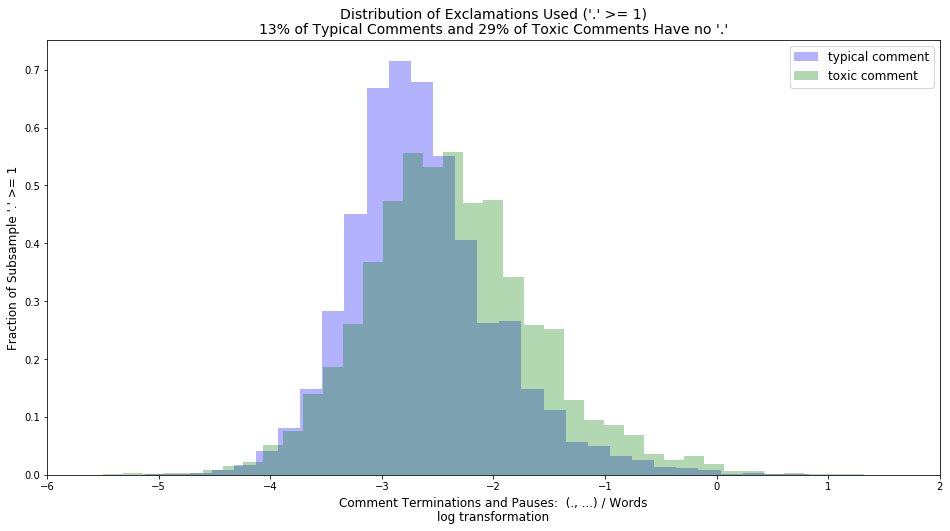

In [188]:
fig, axs = plt.subplots(figsize=(16, 8))

_good = good_stuff[good_stuff.loc[:, "dot_r"] != 0]
_bad = bad_stuff[bad_stuff.loc[:, "dot_r"] != 0]

_ = axs.hist(np.log(_good.loc[:, "dot_r"]), bins=50, normed=True, color='blue', alpha=0.3, label="typical comment")
_ = axs.hist(np.log(_bad.loc[:, "dot_r"]), bins=50, normed=True, color='green', alpha=0.3, label="toxic comment")

axs.legend(fontsize=12)
# axs[1].legend(fontsize=12)

axs.set_xlabel("Comment Terminations and Pauses:  (., ...) / Words\nlog transformation", size=12)
# axs[1].set_xlabel("Comment Urgency: Questions (?) / Words\nlog transformation", size=12)

axs.set_ylabel("Fraction of Subsample '.' >= 1", size=12)
# axs[1].set_ylabel("Fraction of Subsample '?' >= 1", size=12)

axs.set_xlim(-6, 2.0)
# axs[1].set_xlim(-8, 6.0)

axs.set_title("Distribution of Exclamations Used ('.' >= 1)\n13% of Typical Comments and 29% of Toxic Comments Have no '.'", size=14)
# axs[1].set_title("Distribution of Question Marks Used ('?' >= 1)\n74.7% of Toxic Comments Have no '?'", size=14)

### Comment Length:  Words per Comment

Text(0.5,1,'Distribution of Repetition\nToxic Comments')

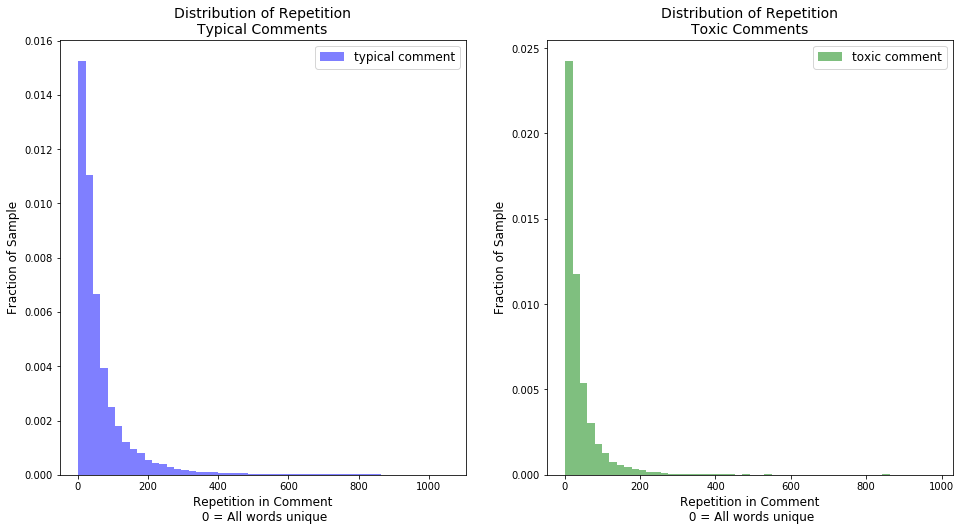

In [189]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

_ = axs[0].hist(good_stuff.loc[:, "word_count"], bins=50, normed=True, color='blue', alpha=0.5, label="typical comment")
_ = axs[1].hist(bad_stuff.loc[:, "word_count"], bins=50, normed=True, color='green', alpha=0.5, label="toxic comment")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

axs[0].set_xlabel("Repetition in Comment\n 0 = All words unique", size=12)
axs[1].set_xlabel("Repetition in Comment\n 0 = All words unique", size=12)

axs[0].set_ylabel("Fraction of Sample", size=12)
axs[1].set_ylabel("Fraction of Sample", size=12)

# axs[0].set_xlim(0, 1.0)
# axs[1].set_xlim(0, 1.0)

axs[0].set_title("Distribution of Repetition\nTypical Comments", size=14)
axs[1].set_title("Distribution of Repetition\nToxic Comments", size=14)

Text(0.5,1,'Distribution of Repetition\nToxic Comments')

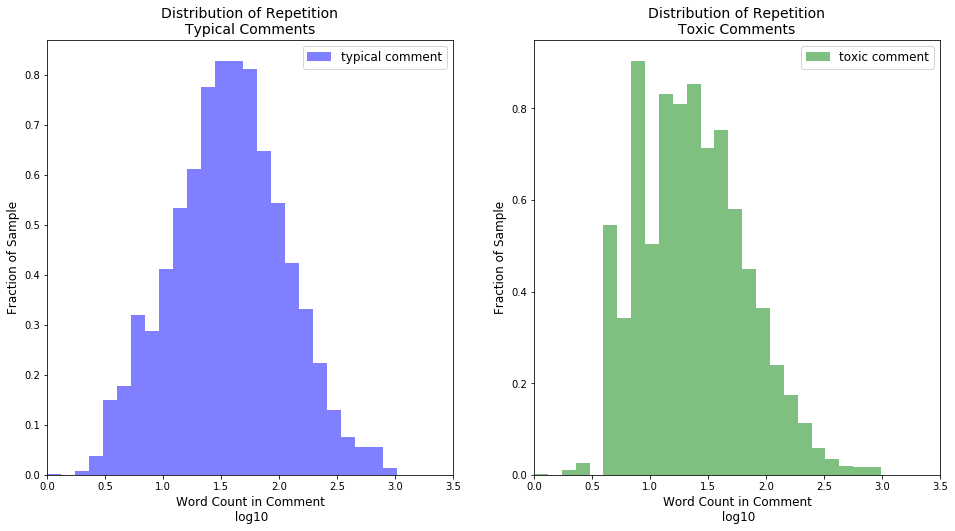

In [201]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

_ = axs[0].hist(np.log10(good_stuff.loc[:, "word_count"]), bins=25, normed=True, color='blue', alpha=0.5, label="typical comment")
_ = axs[1].hist(np.log10(bad_stuff.loc[:, "word_count"]), bins=25, normed=True, color='green', alpha=0.5, label="toxic comment")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

axs[0].set_xlabel("Word Count in Comment\n log10", size=12)
axs[1].set_xlabel("Word Count in Comment\n log10", size=12)

axs[0].set_ylabel("Fraction of Sample", size=12)
axs[1].set_ylabel("Fraction of Sample", size=12)

axs[0].set_xlim(0, 3.5)
axs[1].set_xlim(0, 3.5)

axs[0].set_title("Distribution of Repetition\nTypical Comments", size=14)
axs[1].set_title("Distribution of Repetition\nToxic Comments", size=14)